In [5]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
#read the csvs as dataframes
df_savant_raw = pd.read_csv('savant_data_2021_2023.csv')
df_people = pd.read_csv('lahman_people.csv')

In [4]:
#create column for year
df_savant_raw['year'] = df_savant_raw['game_date'].str[:4].astype(int)

In [5]:
#create dataframe for each at bat
at_bat_ids = df_savant_raw[['batter','pitcher','game_date','year','times_faced']].drop_duplicates()

#assign a unique id to each at bat
at_bat_ids['at_bat_id'] = range(1, len(at_bat_ids) + 1)

#add unique ids to original savant data
df_savant = df_savant_raw.merge(at_bat_ids, on=['batter','pitcher','game_date','year','times_faced'],how='inner')

In [6]:
#create dataframe for player season info
df_players = pd.concat([df_people.assign(year=i) for i in range(2021, 2024)], ignore_index=True)

#remove players without an mlb Id
df_players = df_players[df_players['player_mlb_id'].notna()]

In [81]:
def compute_player_counts(df_players, at_bat_ids, df_savant):
    """
    Computes and adds key baseball statistics for batters and pitchers, including:
    - Total plate appearances (PA) per batter per year.
    - Total batters faced (BF) per pitcher per year.
    - Number of times a base-running event ended an inning.

    The function modifies df_players by merging these computed statistics.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    at_bat_ids : pandas.DataFrame
        DataFrame containing at-bat events with batter, pitcher, and year identifiers.
    df_savant : pandas.DataFrame
        Baseball Savant dataset containing detailed play-by-play event data.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with the following new columns:
        - 'total_pa': Total plate appearances per batter per year.
        - 'total_bf': Total batters faced per pitcher per year.
        - 'base_ended_inn': Count of plate appearances ending due to pickoffs or caught stealing.
    
    Notes:
    ------
    - The function ensures missing values are filled with 0 before merging.
    - Plate appearances that ended due to certain basepath outs (e.g., pickoffs, caught stealing)
      with two outs are subtracted from the total plate appearances.
    """

    # Count total plate appearances for each batter per year
    pa_counts = at_bat_ids.groupby(['batter', 'year'])['at_bat_id'].nunique().reset_index(name='total_pa')
    df_players = df_players.merge(pa_counts, left_on=['player_mlb_id', 'year'], right_on=['batter', 'year'], how='left').drop(columns='batter')
    df_players['total_pa'] = df_players['total_pa'].fillna(0).astype(int)

    # Count total batters faced for each pitcher per year
    bf_counts = at_bat_ids.groupby(['pitcher', 'year'])['at_bat_id'].nunique().reset_index(name='total_bf')
    df_players = df_players.merge(bf_counts, left_on=['player_mlb_id', 'year'], right_on=['pitcher', 'year'], how='left').drop(columns='pitcher')
    df_players['total_bf'] = df_players['total_bf'].fillna(0).astype(int)

    # Define basepath outs that result in an inning ending
    basepath_outs = [
        'caught_stealing_3b', 'caught_stealing_2b', 'pickoff_caught_stealing_2b', 'pickoff_2b',
        'pickoff_caught_stealing_3b', 'pickoff_1b', 'caught_stealing_home', 'pickoff_3b', 'pickoff_caught_stealing_home'
    ]

    # Filter for basepath events that ended an inning (2 outs when the event occurred)
    df_basepath_ends_inning = df_savant[(df_savant['outs_when_up'] == 2) & (df_savant['events'].isin(basepath_outs))]
    count_basepath_ended_ab = df_basepath_ends_inning.groupby(['batter', 'year'])['at_bat_id'].nunique().reset_index(name='base_ended_inn')

    # Merge basepath-ended inning counts and adjust plate appearances
    df_players = df_players.merge(count_basepath_ended_ab, left_on=['player_mlb_id', 'year'], right_on=['batter', 'year'], how='left').drop(columns='batter')
    df_players['base_ended_inn'] = df_players['base_ended_inn'].fillna(0).astype(int)
    df_players['total_pa'] = df_players['total_pa'] - df_players['base_ended_inn']

    return df_players


In [ ]:
#get the counts for the main dataframe
compute_player_counts(df_players, at_bat_ids, df_savant)

In [77]:
#calculate years after debut
df_players['years_after_debut'] = df_players['year'] - df_players['debut'].str[-4:].astype(int)

<Axes: xlabel='total_pa', ylabel='Count'>

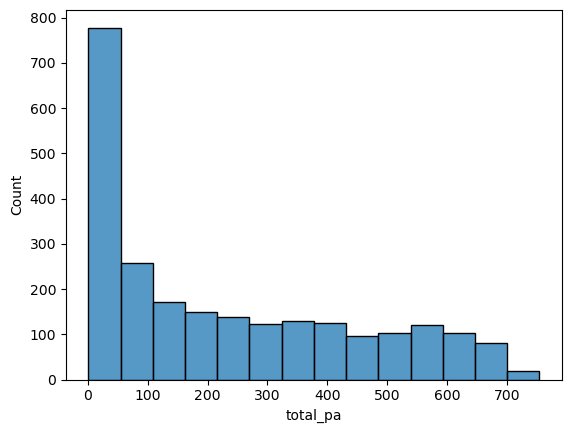

In [10]:
#plot of total plate appearances (min 1). Note this includes pitchers
sns.histplot(pa_counts['total_pa'])

<Axes: xlabel='total_bf', ylabel='Count'>

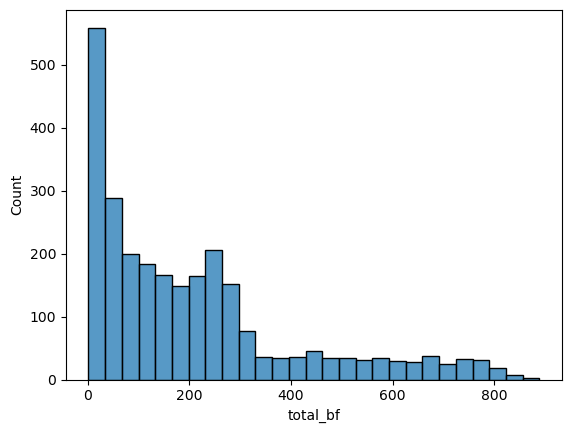

In [11]:
#plot of total batters faced (min 1). Note this includes position players
sns.histplot(bf_counts['total_bf'])

Now calculate what position(s) every player played at in the field (also need to do DH)

In [13]:
#get the fielders for every at bat
df_savant_fielding = df_savant[['at_bat_id','year','pitcher_1',
       'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9']].drop_duplicates()

# #what each position group means
# pitcher_1: MLB Player Id tied to the play event, anonymized via hashing
# fielder_2_1: MLB Player Id for catcher, anonymized via hashing
# fielder_3: MLB Player Id for 1B, anonymized via hashing
# fielder_4: MLB Player Id for 2B, anonymized via hashing
# fielder_5: MLB Player Id for 3B, anonymized via hashing
# fielder_6: MLB Player Id for SS, anonymized via hashing
# fielder_7: MLB Player Id for LF, anonymized via hashing
# fielder_8: MLB Player Id for CF, anonymized via hashing
# fielder_9: MLB Player Id for RF, anonymized via hashing

In [14]:
# # List of pitcher columns (or any other relevant columns)
# pitcher_columns = ['pitcher_1', 'fielder_2_1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
#        'fielder_7', 'fielder_8', 'fielder_9']  # Modify this list as needed

# # Loop over the list of pitcher columns
# for pitcher_col in pitcher_columns:
#     # Compute the counts for each pitcher column
#     count_df = df_savant_fielding.groupby([pitcher_col, 'year']).size().reset_index(name='count')
    
#     # Merge the count data with df_players
#     df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[pitcher_col, 'year'])
    
#     # Fill NaN values with 0 and ensure the count is an integer
#     df_players['count'] = df_players['count'].fillna(0).astype(int)
    
#     # Optional: Rename the count column to differentiate between different pitcher columns
#     df_players.rename(columns={'count': f'count_{pitcher_col}'}, inplace=True)


In [15]:
# First, compute the counts

#list of each position column name
fielding_columns = ['pitcher_1', 'fielder_2_1', 'fielder_3', 
                    'fielder_4', 'fielder_5', 'fielder_6',
                    'fielder_7', 'fielder_8', 'fielder_9']

#dictionary to change position column to more recognizable name
fielding_dict = {'pitcher_1':'p', 'fielder_2_1':'c', 'fielder_3':'1b', 
                 'fielder_4':'2b', 'fielder_5':'3b', 'fielder_6':'ss',
                 'fielder_7':'lf', 'fielder_8':'cf', 'fielder_9':'rf'}

#get count for every player at every position
for col in fielding_columns:
    col_name = 'field_' + fielding_dict[col]
    count_df = df_savant_fielding.groupby([col, 'year']).size().reset_index(name=col_name)
    
    #add count to main dataframe
    df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[col, 'year']).drop(columns=col)
    
    #fill NaN with 0
    df_players[col_name] = df_players[col_name].fillna(0).astype(int)


In [16]:
df_players.head()

,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,throws,...,base_ended_inn,field_p,field_c,field_1b,field_2b,field_3b,field_ss,field_lf,field_cf,field_rf
0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,0.0,81,0,0,0,0,0,0,0,0
1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,R,...,0.0,82,0,0,0,0,0,0,0,0
2,f79cf1f3d100e5f34d86ce2cd4c8c35ca3daee77,e195c4bc19cb6a08203e3c9e361677b73dbfdc03,2000,10,3,USA,185,74,L,R,...,0.0,0,0,0,0,0,0,0,0,0
3,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,R,...,0.0,161,0,0,0,0,0,0,0,0
4,80f3a94c7bf1ed6397017744dbb75ff931902e2d,d851612368c1e9612c0c2a444018af96a59bf0b9,1987,1,29,Cuba,235,75,R,R,...,0.0,0,0,4822,0,1,0,0,0,0


In [39]:
df_players.columns

Index(['player_mlb_id', 'playerID_LAHMAN', 'birthYear', 'birthMonth',
       'birthDay', 'birthCountry', 'weight', 'height', 'bats', 'throws',
       'debut', 'birthDate', 'year', 'total_pa', 'total_bf', 'base_ended_inn',
       'field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 'field_ss',
       'field_lf', 'field_cf', 'field_rf', 'years_after_debut'],
      dtype='object')

In [41]:
def get_count_for_batter_event(df_player, df_sav, event, player_type):
    """
    Computes the number of occurrences of a specific baseball event for each player in a given year 
    and adds the count as a new column to the player dataframe.

    Parameters:
    -----------
    df_player : pandas.DataFrame
        DataFrame containing player information, including player IDs and years.
    df_sav : pandas.DataFrame
        Baseball Savant dataset containing event details.
    event : str
        The specific event to count (e.g., 'home_run', 'strikeout').
    player_type : str
        Specifies whether to filter data by 'batter' or 'pitcher' statistics.

    Returns:
    --------
    pandas.DataFrame
        The input df_player with an additional column representing the count of the specified event 
        for each player per year.
    """
    
    #filter to specified event
    df_filter = df_sav[df_sav['events'] == event]

    #get event count for every batter/year combo
    col_name = player_type + '_' + event
    count_df = df_filter.groupby([player_type, 'year']).size().reset_index(name=col_name)

    #add column to main dataframe
    df_player = df_player.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[player_type, 'year']).drop(columns=player_type)
    df_player[col_name] = df_player[col_name].fillna(0).astype(int)

    return df_player

    #df_players = df_players.merge(count_df, how='left', left_on=['player_mlb_id', 'year'], right_on=[col, 'year']).drop(columns=col)

    

In [43]:
df_savant.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,...,delta_home_win_exp,delta_run_exp,role_key,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced,year,at_bat_id
0,FF,2021-04-05,93.2,0.84,5.74,c7c83eaa9fe8da2f81c5fce172059af61448b3e7,4f902241478a103f7a818f5be9a7b7ddf43cabb9,strikeout,swinging_strike,13.0,...,-0.014,-0.134,SP,1,0,97,22,3,2021,1
1,SL,2021-04-05,82.9,1.03,5.69,c7c83eaa9fe8da2f81c5fce172059af61448b3e7,4f902241478a103f7a818f5be9a7b7ddf43cabb9,NaN,foul,5.0,...,0.000,0.000,SP,1,0,96,22,3,2021,1
2,FF,2021-04-05,94.6,-1.85,5.77,514eeb6e6c17085fc1adabf03f1adca32318411f,afb9b85defc6fe5c3f48681480eff4d96ab723c7,caught_stealing_3b,ball,14.0,...,0.014,-0.202,SP,1,0,95,19,3,2021,2
3,FF,2021-04-05,97.1,1.86,6.57,875eeca87c6f80182a88c2a7b92c048b9e10b5e5,0f061b9439845159c394a71e55d635b10ca25656,field_out,hit_into_play,13.0,...,-0.007,-0.264,SP,1,0,95,22,3,2021,3
4,FF,2021-04-05,93.6,0.60,5.85,c7c83eaa9fe8da2f81c5fce172059af61448b3e7,4f902241478a103f7a818f5be9a7b7ddf43cabb9,NaN,ball,11.0,...,0.000,0.043,SP,1,0,95,22,3,2021,1


In [45]:
df_savant['events'].unique()

array(['strikeout', nan, 'caught_stealing_3b', 'field_out', 'walk',
       'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
       'grounded_into_double_play', 'sac_bunt', 'home_run',
       'fielders_choice', 'field_error', 'other_out',
       'caught_stealing_2b', 'triple', 'strikeout_double_play',
       'fielders_choice_out', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
       'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
       'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
       'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
       'stolen_base_3b'], dtype=object)

In [47]:
#get counts for key batting events
batting_events = ['strikeout', 'caught_stealing_3b', 'field_out', 'walk',
       'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
       'grounded_into_double_play', 'sac_bunt', 'home_run',
       'fielders_choice', 'field_error', 'other_out',
       'caught_stealing_2b', 'triple', 'strikeout_double_play',
       'fielders_choice_out', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
       'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
       'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
       'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
       'stolen_base_3b']

for event in batting_events:
    df_players = get_count_for_batter_event(df_players, df_savant, event, 'batter')


In [48]:
#get counts for key pitching events
batting_events = ['strikeout', 'caught_stealing_3b', 'field_out', 'walk',
       'force_out', 'sac_fly', 'single', 'hit_by_pitch', 'double',
       'grounded_into_double_play', 'sac_bunt', 'home_run',
       'fielders_choice', 'field_error', 'other_out',
       'caught_stealing_2b', 'triple', 'strikeout_double_play',
       'fielders_choice_out', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'pickoff_caught_stealing_2b', 'pickoff_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b',
       'sac_bunt_double_play', 'wild_pitch', 'game_advisory',
       'caught_stealing_home', 'pickoff_3b', 'stolen_base_2b',
       'passed_ball', 'pickoff_caught_stealing_home', 'pickoff_error_3b',
       'stolen_base_3b']

for event in batting_events:
    df_players = get_count_for_batter_event(df_players, df_savant, event, 'pitcher')


In [49]:
# Calculate new baseball stats
# Hits (already calculated)
df_players['hits'] = df_players['batter_single'] + df_players['batter_double'] + df_players['batter_triple'] + df_players['batter_home_run']

# Eligible plate appearances
df_players['elig_pa'] = df_players['total_pa'] - df_players['batter_sac_fly'] - df_players['batter_sac_bunt'] - df_players['batter_walk'] - df_players['batter_hit_by_pitch']

# Batting Average (AVG)
df_players['avg'] = df_players['hits'] / df_players['elig_pa']

# Total Bases (TB)
df_players['tb'] = df_players['batter_single'] + 2 * df_players['batter_double'] + 3 * df_players['batter_triple'] + 4 * df_players['batter_home_run']

# Slugging Percentage (SLG)
df_players['slg'] = df_players['tb'] / df_players['elig_pa']

# On-Base Percentage (OBP)
df_players['obp'] = (df_players['hits'] + df_players['batter_walk'] + df_players['batter_hit_by_pitch']) / \
                    (df_players['elig_pa'] + df_players['batter_walk'] + df_players['batter_hit_by_pitch'] + df_players['batter_sac_fly'])

# On-Base Plus Slugging (OPS)
df_players['ops'] = df_players['obp'] + df_players['slg']

# Weighted On-Base Average (wOBA) - simplified
df_players['woba'] = (
    0.69 * df_players['batter_walk'] +
    0.72 * df_players['batter_hit_by_pitch'] +
    0.89 * df_players['batter_single'] +
    1.27 * df_players['batter_double'] +
    1.62 * df_players['batter_triple'] +
    2.10 * df_players['batter_home_run']
) / df_players['total_pa']

# Batting Average on Balls in Play (BABIP)
df_players['babip'] = (
    df_players['hits'] - df_players['batter_home_run']
) / (
    df_players['elig_pa'] - df_players['batter_walk'] - df_players['batter_hit_by_pitch'] - df_players['batter_home_run'] - df_players['batter_strikeout']
)

# Strikeout Rate (K%)
df_players['k_rate'] = df_players['batter_strikeout'] / df_players['elig_pa']

# Walk Rate (BB%)
df_players['bb_rate'] = df_players['batter_walk'] / df_players['elig_pa']

# Home Run Rate (HR%)
df_players['hr_rate'] = df_players['batter_home_run'] / df_players['elig_pa']

# Isolated Power (ISO)
df_players['iso'] = df_players['slg'] - df_players['avg']

# Extra Base Hits (XBH)
df_players['xbh'] = df_players['batter_double'] + df_players['batter_triple'] + df_players['batter_home_run']

# Runs Created (RC) - simplified
df_players['rc'] = (df_players['hits'] + df_players['batter_walk']) * df_players['tb'] / df_players['elig_pa']

# Plate Appearances Per Strikeout (PA/K)
df_players['pa_per_k'] = df_players['elig_pa'] / df_players['batter_strikeout']

# Plate Appearances Per Walk (PA/BB)
df_players['pa_per_bb'] = df_players['elig_pa'] / df_players['batter_walk']

# Fielding Percentage (FP%)
df_players['fielding_percentage'] = df_players['field_p'] / \
    (df_players['field_p'] + df_players['batter_field_error'])

# Defensive Versatility (Number of Positions Played)
df_players['positions_played'] = df_players[['field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 
                                             'field_ss', 'field_lf', 'field_cf', 'field_rf']].gt(0).sum(axis=1)


In [83]:
#need to calculate splits
df_savant_r = df_savant[df_savant['p_throws'] == 'R']
df_savant_l = df_savant[df_savant['p_throws'] == 'L']

#
df_players_r = pd.concat([df_people.assign(year=i) for i in range(2021, 2024)], ignore_index=True)
df_players_l = pd.concat([df_people.assign(year=i) for i in range(2021, 2024)], ignore_index=True)

#redo counts
compute_player_counts(df_players_r, at_bat_ids, df_savant_r)
compute_player_counts(df_players_l, at_bat_ids, df_savant_l)

,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,throws,debut,birthDate,year,total_pa,total_bf,base_ended_inn
0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,7/28/2010,12/17/1985,2021,0,81,0
1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,R,6/5/2021,9/20/1995,2021,3,82,0
2,f79cf1f3d100e5f34d86ce2cd4c8c35ca3daee77,e195c4bc19cb6a08203e3c9e361677b73dbfdc03,2000,10,3,USA,185,74,L,R,4/8/2022,10/3/2000,2021,0,0,0
3,NaN,7265712e9970a0afa6ad8214b7425382051f06da,1995,9,26,D.R.,190,74,R,R,8/8/2020,9/26/1995,2021,0,0,0
4,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,R,7/31/2019,4/22/1997,2021,0,161,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,fb700ef074fe19c9c4328e120dd91c7b03c044cc,a5c53be1f59100143df6f70f01d850c5051c8da8,1996,12,1,USA,240,78,R,R,9/27/2023,12/1/1996,2023,0,14,0
9116,0cb4ea486038c8edcb71036139fcef171a27fe97,d05f17e03fd8f465d6b97ea2b9885822c6860a51,2000,1,26,D.R.,205,73,R,R,9/27/2023,1/26/2000,2023,0,8,0
9117,128f3d8f2092540735e1a741529518b8058d4758,a504d79a7e6fcabd6edf101e0e4b4595a76534b3,1999,10,15,Venezuela,212,75,R,R,9/28/2023,10/15/1999,2023,0,8,0
9118,11414d3c42573a52b9032d1287494a78a912c4af,5ce7c85f4bb5cb6c5007588ebef4ae7234e835d1,1993,10,1,USA,190,75,R,R,9/29/2023,10/1/1993,2023,0,10,0


In [87]:
df_players_l.head()

,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,throws,debut,birthDate,year
0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,7/28/2010,12/17/1985,2021
1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,R,6/5/2021,9/20/1995,2021
2,f79cf1f3d100e5f34d86ce2cd4c8c35ca3daee77,e195c4bc19cb6a08203e3c9e361677b73dbfdc03,2000,10,3,USA,185,74,L,R,4/8/2022,10/3/2000,2021
3,NaN,7265712e9970a0afa6ad8214b7425382051f06da,1995,9,26,D.R.,190,74,R,R,8/8/2020,9/26/1995,2021
4,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,R,7/31/2019,4/22/1997,2021


In [50]:
#Stats for pitchers

In [51]:
df_players['avg'].head()

0         NaN
1    0.333333
2         NaN
3         NaN
4    0.261023
Name: avg, dtype: float64

In [52]:
def linear_regression_scatter(df, x, y, min_x=False, min_y=False):
    """
    This function filters out missing values and optionally removes entries that do not meet 
    specified minimum thresholds for the x and y variables. It then fits a simple linear 
    regression model, plots the data points, and overlays the regression line.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing the variables to be plotted.
    x : str
        The column name representing the independent variable.
    y : str
        The column name representing the dependent variable.
    min_x : float or bool, optional (default=False)
        The minimum threshold for filtering x values. Entries with x < min_x will be removed.
    min_y : float or bool, optional (default=False)
        The minimum threshold for filtering y values. Entries with y < min_y will be removed.

    Returns: None
    """
    
    #filter entries to where columns aren't null
    df = df[df[x].notnull() & df[y].notnull()]

    #filter out player who do not meet the min
    if min_x != False:
        df = df[df[x] >= min_x]
    
    if min_y != False:
        df = df[df[y] >= min_y]
    
    #get passed columns 
    x_vals = df[x]
    y_vals = df[y]
    
    #perform linear regression
    slope, intercept, r, p, std_err = stats.linregress(x_vals, y_vals)
    
    #define regression function
    def myfunc(x_vals):
        return slope * x_vals + intercept
    
    #generate regression line values
    mymodel = list(map(myfunc, x_vals))
    
    #create scatter plot with regression line
    plt.figure(figsize=(10, 6))  # Increase figure size for better readability
    sns.set_theme(style="whitegrid")  # Use a clean theme
    
    #scatter plot
    sns.scatterplot(x=x_vals, y=y_vals, color="blue", alpha=0.6, s=60, label="Player Data")
    
    #regression line
    plt.plot(x_vals, mymodel, color="red", linewidth=2, label=f"Regression Line (a: {slope:.2f}, b: {intercept:.2f}, R²={r**2:.2f})")
    
    #add text and plot
    plt.title(f"Relationship Between {x} and {y}", fontsize=16)
    plt.xlabel(f"{x}", fontsize=14)
    plt.ylabel(f"{y}", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

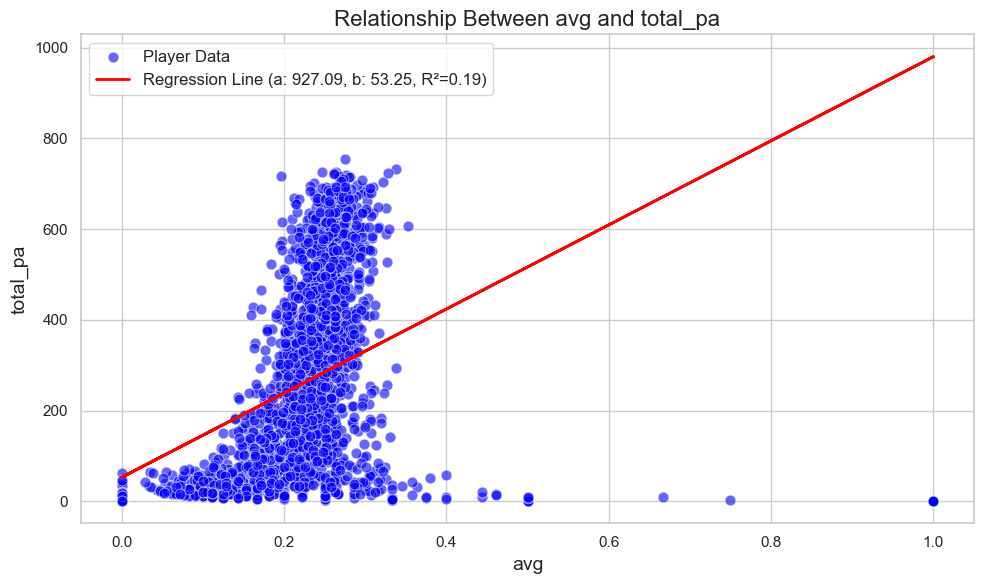

In [53]:
linear_regression_scatter(df_players,'avg','total_pa')

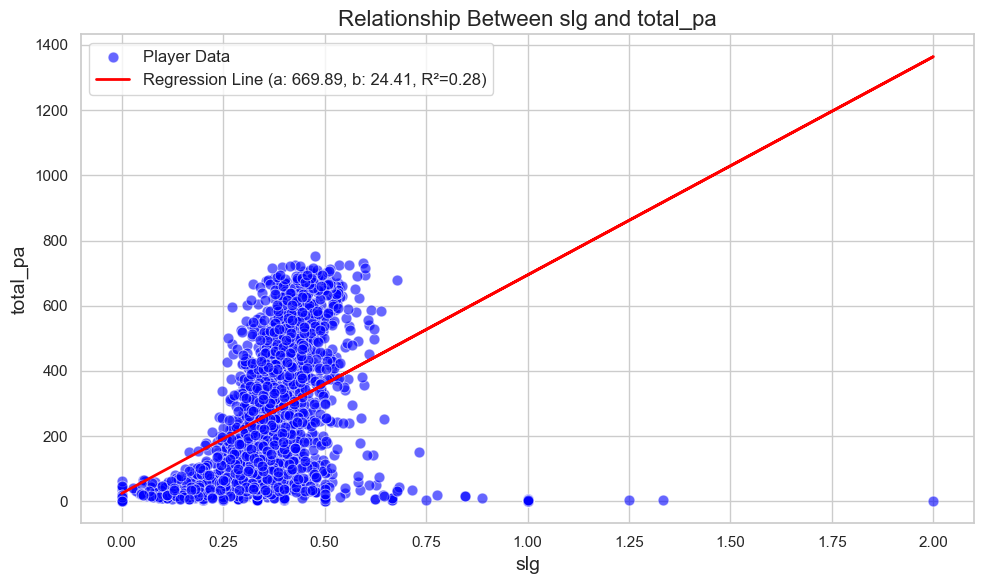

In [54]:
linear_regression_scatter(df_players,'slg','total_pa')

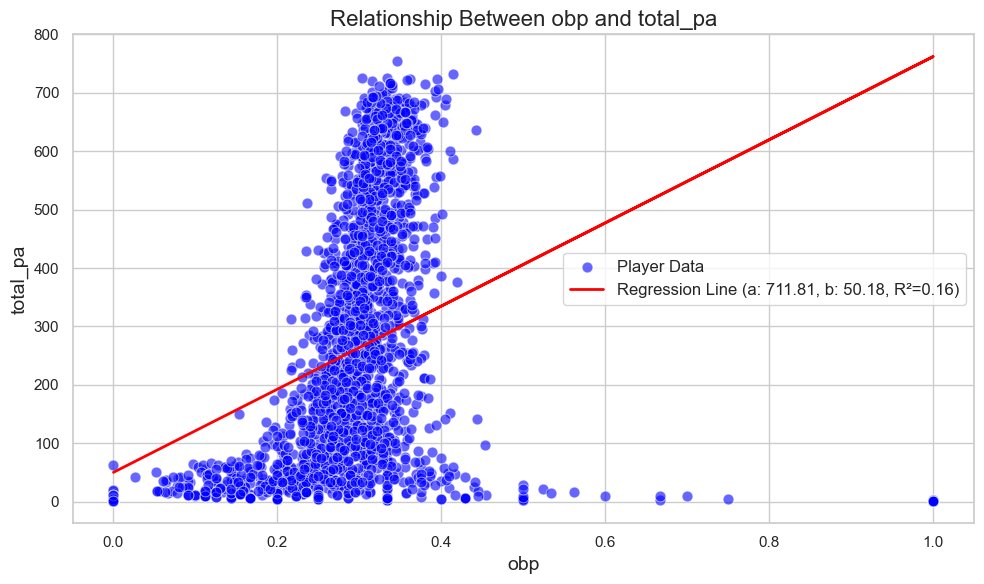

In [55]:
linear_regression_scatter(df_players,'obp','total_pa')

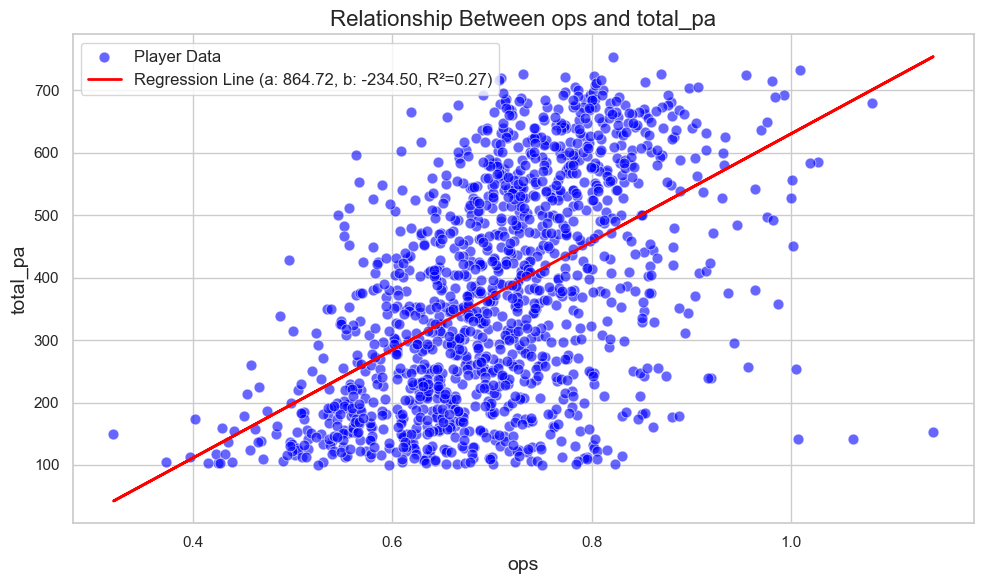

In [93]:
linear_regression_scatter(df_players,'ops','total_pa', min_y=100)

In [101]:
for i in df_players.columns:
    print(i + ',')

player_mlb_id,
playerID_LAHMAN,
birthYear,
birthMonth,
birthDay,
birthCountry,
weight,
height,
bats,
throws,
debut,
birthDate,
year,
total_pa,
total_bf,
base_ended_inn,
field_p,
field_c,
field_1b,
field_2b,
field_3b,
field_ss,
field_lf,
field_cf,
field_rf,
years_after_debut,
batter_strikeout,
batter_caught_stealing_3b,
batter_field_out,
batter_walk,
batter_force_out,
batter_sac_fly,
batter_single,
batter_hit_by_pitch,
batter_double,
batter_grounded_into_double_play,
batter_sac_bunt,
batter_home_run,
batter_fielders_choice,
batter_field_error,
batter_other_out,
batter_caught_stealing_2b,
batter_triple,
batter_strikeout_double_play,
batter_fielders_choice_out,
batter_double_play,
batter_sac_fly_double_play,
batter_catcher_interf,
batter_pickoff_caught_stealing_2b,
batter_pickoff_2b,
batter_pickoff_caught_stealing_3b,
batter_triple_play,
batter_pickoff_1b,
batter_sac_bunt_double_play,
batter_wild_pitch,
batter_game_advisory,
batter_caught_stealing_home,
batter_pickoff_3b,
batter_stolen_ba

In [47]:
df_players = pd.read_csv('df_players.csv')

In [100]:
df_players_simple = df_players

In [102]:
df_players_simple['check'] = df_players_simple[['total_pa', 'field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 'field_ss', 'field_lf', 'field_cf', 'field_rf']].sum(axis=1)
df_players_simple['total_field'] = df_players_simple[['field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 'field_ss', 'field_lf', 'field_cf', 'field_rf']].sum(axis=1)

In [104]:
df_players_check = df_players_simple[df_players_simple['check'] > 0]

In [107]:
df_players_check

,Unnamed: 0,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,...,hr_rate,iso,xbh,rc,pa_per_k,pa_per_bb,fielding_percentage,positions_played,check,total_field
0,0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,...,NaN,NaN,0,NaN,NaN,NaN,1.0,1,81.0,81
1,1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,...,0.00000,0.000000,0,0.333333,3.000000,inf,1.0,1,85.0,82
3,3,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,...,NaN,NaN,0,NaN,NaN,NaN,1.0,1,161.0,161
4,4,80f3a94c7bf1ed6397017744dbb75ff931902e2d,d851612368c1e9612c0c2a444018af96a59bf0b9,1987,1,29,Cuba,235,75,R,...,0.05291,0.218695,62,98.821869,3.965035,9.775862,0.0,2,5480.0,4823
5,5,3304ddb1ae3c28e484f383e6609fd35f1778ddf7,c8bc5aabe2cccc7fb3b5e9d74cd9ee9ee67be704,1994,3,6,D.R.,240,79,R,...,NaN,NaN,0,NaN,NaN,NaN,1.0,1,44.0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7471,7471,fb700ef074fe19c9c4328e120dd91c7b03c044cc,a5c53be1f59100143df6f70f01d850c5051c8da8,1996,12,1,USA,240,78,R,...,NaN,NaN,0,NaN,NaN,NaN,1.0,1,14.0,14
7472,7472,0cb4ea486038c8edcb71036139fcef171a27fe97,d05f17e03fd8f465d6b97ea2b9885822c6860a51,2000,1,26,D.R.,205,73,R,...,NaN,NaN,0,NaN,NaN,NaN,1.0,1,8.0,8
7473,7473,128f3d8f2092540735e1a741529518b8058d4758,a504d79a7e6fcabd6edf101e0e4b4595a76534b3,1999,10,15,Venezuela,212,75,R,...,NaN,NaN,0,NaN,NaN,NaN,1.0,1,8.0,8
7474,7474,11414d3c42573a52b9032d1287494a78a912c4af,5ce7c85f4bb5cb6c5007588ebef4ae7234e835d1,1993,10,1,USA,190,75,R,...,NaN,NaN,0,NaN,NaN,NaN,1.0,1,10.0,10


In [109]:
field_columns = ['field_p', 'field_c', 'field_1b', 'field_2b', 'field_3b', 'field_ss', 'field_lf', 'field_cf', 'field_rf']

for col in field_columns:
    df_players_check[f'{col}_ratio'] = df_players_check[col] / df_players_check['total_field']


C:\Users\kenva\AppData\Local\Temp\ipykernel_8788\2507333180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_check[f'{col}_ratio'] = df_players_check[col] / df_players_check['total_field']
C:\Users\kenva\AppData\Local\Temp\ipykernel_8788\2507333180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_check[f'{col}_ratio'] = df_players_check[col] / df_players_check['total_field']
C:\Users\kenva\AppData\Local\Temp\ipykernel_8788\2507333180.py:4: SettingWithCopyWarning: 
A value is tryi

In [111]:
df_players_check

,Unnamed: 0,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,...,total_field,field_p_ratio,field_c_ratio,field_1b_ratio,field_2b_ratio,field_3b_ratio,field_ss_ratio,field_lf_ratio,field_cf_ratio,field_rf_ratio
0,0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,...,81,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,...,82,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,3,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,...,161,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,4,80f3a94c7bf1ed6397017744dbb75ff931902e2d,d851612368c1e9612c0c2a444018af96a59bf0b9,1987,1,29,Cuba,235,75,R,...,4823,0.0,0.0,0.999793,0.0,0.000207,0.0,0.0,0.0,0.0
5,5,3304ddb1ae3c28e484f383e6609fd35f1778ddf7,c8bc5aabe2cccc7fb3b5e9d74cd9ee9ee67be704,1994,3,6,D.R.,240,79,R,...,44,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7471,7471,fb700ef074fe19c9c4328e120dd91c7b03c044cc,a5c53be1f59100143df6f70f01d850c5051c8da8,1996,12,1,USA,240,78,R,...,14,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7472,7472,0cb4ea486038c8edcb71036139fcef171a27fe97,d05f17e03fd8f465d6b97ea2b9885822c6860a51,2000,1,26,D.R.,205,73,R,...,8,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7473,7473,128f3d8f2092540735e1a741529518b8058d4758,a504d79a7e6fcabd6edf101e0e4b4595a76534b3,1999,10,15,Venezuela,212,75,R,...,8,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
7474,7474,11414d3c42573a52b9032d1287494a78a912c4af,5ce7c85f4bb5cb6c5007588ebef4ae7234e835d1,1993,10,1,USA,190,75,R,...,10,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [113]:
ratio_columns = ['field_p_ratio', 'field_c_ratio', 'field_1b_ratio', 'field_2b_ratio', 
                 'field_3b_ratio', 'field_ss_ratio', 'field_lf_ratio', 'field_cf_ratio', 'field_rf_ratio']

df_players_check['primary_position'] = df_players_check[ratio_columns].idxmax(axis=1).str.replace('_ratio', '').str.replace('field_', '')

C:\Users\kenva\AppData\Local\Temp\ipykernel_8788\4275711580.py:4: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_players_check['primary_position'] = df_players_check[ratio_columns].idxmax(axis=1).str.replace('_ratio', '').str.replace('field_', '')
C:\Users\kenva\AppData\Local\Temp\ipykernel_8788\4275711580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players_check['primary_position'] = df_players_check[ratio_columns].idxmax(axis=1).str.replace('_ratio', '').str.replace('field_', '')


In [115]:
df_players_check

,Unnamed: 0,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,...,field_p_ratio,field_c_ratio,field_1b_ratio,field_2b_ratio,field_3b_ratio,field_ss_ratio,field_lf_ratio,field_cf_ratio,field_rf_ratio,primary_position
0,0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,p
1,1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,p
3,3,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,p
4,4,80f3a94c7bf1ed6397017744dbb75ff931902e2d,d851612368c1e9612c0c2a444018af96a59bf0b9,1987,1,29,Cuba,235,75,R,...,0.0,0.0,0.999793,0.0,0.000207,0.0,0.0,0.0,0.0,1b
5,5,3304ddb1ae3c28e484f383e6609fd35f1778ddf7,c8bc5aabe2cccc7fb3b5e9d74cd9ee9ee67be704,1994,3,6,D.R.,240,79,R,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7471,7471,fb700ef074fe19c9c4328e120dd91c7b03c044cc,a5c53be1f59100143df6f70f01d850c5051c8da8,1996,12,1,USA,240,78,R,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,p
7472,7472,0cb4ea486038c8edcb71036139fcef171a27fe97,d05f17e03fd8f465d6b97ea2b9885822c6860a51,2000,1,26,D.R.,205,73,R,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,p
7473,7473,128f3d8f2092540735e1a741529518b8058d4758,a504d79a7e6fcabd6edf101e0e4b4595a76534b3,1999,10,15,Venezuela,212,75,R,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,p
7474,7474,11414d3c42573a52b9032d1287494a78a912c4af,5ce7c85f4bb5cb6c5007588ebef4ae7234e835d1,1993,10,1,USA,190,75,R,...,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,p


In [117]:
def linear_regression_scatter(df, x, y, min_x=False, min_y=False):
    """
    This function filters out missing values and optionally removes entries that do not meet 
    specified minimum thresholds for the x and y variables. It then fits a simple linear 
    regression model, plots the data points, and overlays the regression line.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing the variables to be plotted.
    x : str
        The column name representing the independent variable.
    y : str
        The column name representing the dependent variable.
    min_x : float or bool, optional (default=False)
        The minimum threshold for filtering x values. Entries with x < min_x will be removed.
    min_y : float or bool, optional (default=False)
        The minimum threshold for filtering y values. Entries with y < min_y will be removed.

    Returns: None
    """
    
    #filter entries to where columns aren't null
    df = df[df[x].notnull() & df[y].notnull()]

    #filter out player who do not meet the min
    if min_x != False:
        df = df[df[x] >= min_x]
    
    if min_y != False:
        df = df[df[y] >= min_y]
    
    #get passed columns 
    x_vals = df[x]
    y_vals = df[y]
    
    #perform linear regression
    slope, intercept, r, p, std_err = stats.linregress(x_vals, y_vals)
    
    #define regression function
    def myfunc(x_vals):
        return slope * x_vals + intercept
    
    #generate regression line values
    mymodel = list(map(myfunc, x_vals))
    
    #create scatter plot with regression line
    plt.figure(figsize=(10, 6))  # Increase figure size for better readability
    sns.set_theme(style="whitegrid")  # Use a clean theme
    
    #scatter plot
    sns.scatterplot(x=x_vals, y=y_vals, color="blue", alpha=0.6, s=60, label="Player Data")
    
    #regression line
    plt.plot(x_vals, mymodel, color="red", linewidth=2, label=f"Regression Line (a: {slope:.2f}, b: {intercept:.2f}, R²={r**2:.2f})")
    
    #add text and plot
    plt.title(f"Relationship Between {x} and {y}", fontsize=16)
    plt.xlabel(f"{x}", fontsize=14)
    plt.ylabel(f"{y}", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [125]:
df_players_check_100 = df_players_check[df_players_check['total_pa'] > 100]
df_players_check_100.groupby('primary_position')['ops'].mean()

primary_position
1b    0.741980
2b    0.690839
3b    0.706828
c     0.668268
cf    0.696555
lf    0.717333
p     0.936773
rf    0.733529
ss    0.688669
Name: ops, dtype: float64

In [135]:
df_players_check_100[df_players_check_100['primary_position'] == 'p']['ops']

1468    0.934435
3960    0.856587
6452    1.019296
Name: ops, dtype: float64